## 1. Downloading and Working with Imaging Data

Test object: NGC 1309

### 1a. Looking at the data

In [1]:
# read in the data
from astropy.io import fits
g = fits.open('cutout_rings.v3.skycell.0978.011.stk.g.unconv.fits')
i = fits.open('cutout_rings.v3.skycell.0978.011.stk.i.unconv.fits')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# what does the data look like?
import matplotlib.pyplot as plt
import numpy as np

g[0].data

array([[ -12.390256 ,   74.34176  ,  -14.744849 , ...,  -79.02288  ,
          28.637852 ,    2.313655 ],
       [  62.33944  ,   31.881527 , -115.10421  , ...,  -86.72658  ,
        -129.99918  ,   -2.5913482],
       [ -49.40202  ,  -61.498997 ,  -26.77069  , ...,    1.4142216,
          81.2733   ,   -9.352829 ],
       ...,
       [  42.0754   ,   16.876923 ,   35.571724 , ...,   81.11716  ,
          68.75572  ,   21.904076 ],
       [  21.991055 ,  -88.896    ,   72.19834  , ...,   -0.1491473,
          59.449684 ,   70.92078  ],
       [ -30.44643  ,  -77.53699  ,   86.53618  , ...,  106.65325  ,
          48.557037 ,   66.92802  ]], dtype='>f4')

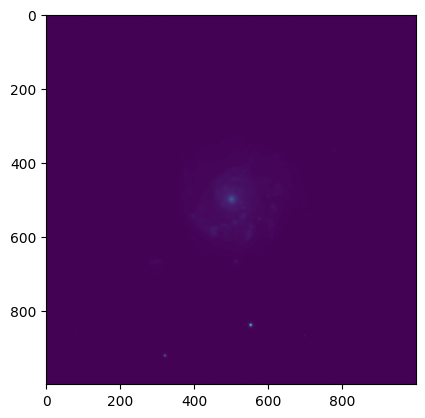

In [3]:
# let's display it
plt.imshow(g[0].data)

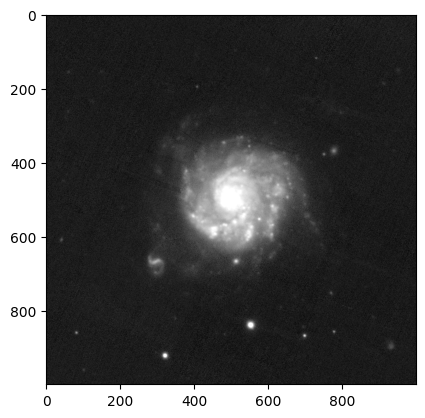

In [4]:
# let's fix the contrast
from astropy.visualization import AsinhStretch
from astropy.visualization import PercentileInterval

def scale_image(image_data):
    transform = AsinhStretch() + PercentileInterval(99.5)
    scaled_data = transform(image_data)

    return scaled_data

plt.imshow(scale_image(g[0].data),cmap='gray')

### 1b. Basic photometry

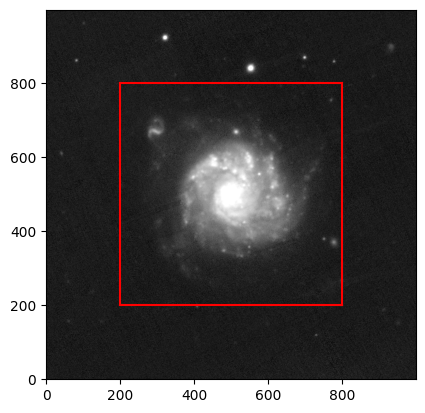

In [5]:
# let's draw a square and count up the flux
plt.imshow(scale_image(g[0].data),cmap='gray',origin='lower')
plt.plot([200,800],[200,200],color='r')
plt.plot([200,200],[200,800],color='r')
plt.plot([800,800],[800,200],color='r')
plt.plot([200,800],[800,800],color='r')

In [6]:
flux_g = np.sum(g[0].data[200:800,200:800])
mag_g = -2.5*np.log10(flux_g) + 25 + 2.5*np.log10(g[0].header['EXPTIME'])

flux_i = np.sum(i[0].data[200:800,200:800])
mag_i = -2.5*np.log10(flux_i) + 25 + 2.5*np.log10(i[0].header['EXPTIME'])

print(f'g mag: {mag_g}')
print(f'i mag: {mag_i}')

g mag: 11.809373308222685
i mag: 11.281841792795786


In [7]:
# more typical: circular aperture
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
positions = [(500.0, 500.0)]
aperture = CircularAperture(positions, r=200)
phot_table = aperture_photometry(g[0].data, aperture)
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,500.0,500.0,108502581.16384774


In [8]:
-2.5*np.log10(phot_table['aperture_sum']) + 25 + 2.5*np.log10(g[0].header['EXPTIME'])

11.860391053837976


### Class Exercise: Is the color of the bulge different than the color of the disk?

## 2. Working with Catalog Data

Catalogs of measured astrophysical objects exist for many surveys.  These can be accessed through web forms, or through dedicated application program interfaces (APIs).  For Pan-STARRS, instructions at https://ps1images.stsci.edu/ps1_dr2_api.html tell us that we can use the link format:

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean.json?ra=50.52731519175667&dec=-15.399947901113887&radius=0.0002

In [9]:
import requests
ra = 50.52731519175667
dec = -15.399947901113887
radius=0.0002
data = requests.get(
    f'https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean.json?ra={ra}&dec={dec}&radius={radius}'
    ).json()
#data

In [10]:
# ugh.  let's try CSV
import astropy.table as at
r = requests.get(
    f'https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean.csv?ra={ra}&dec={dec}&radius={radius}'
    )
data = at.Table.read(r.text,format='ascii')

In [11]:
# and we can get the measurements
data['gMeanKronMag']

11.96660041809082


In [12]:
# and now if you want to simplify further
from astroquery.mast import Catalogs
radius = 2
catalog_data = Catalogs.query_object(f"{ra} {dec}",radius=f"{radius} arcsec",catalog="PanSTARRS")

In [13]:
catalog_data['gMeanKronMag']

--
--
11.96660041809082
--
--


open-ended SQL queries
https://galex.stsci.edu/casjobs/SubmitJob.aspx

select top 100 p.objid, p.ra, p.dec, p.glon, p.glat,
p.nuv_mag, p.nuv_magerr, p.fuv_mag, p.fuv_magerr,
p.e_bv, pe.mpstype as survey
from photoobjall as p, photoextract as pe
where p.photoextractid=pe.photoextractid
and p.nuv_mag>-99 and p.band=3
and p.nuv_fwhm_world<.01
order by p.nuv_mag


### Class Exercise: Find UV or Near-Infared Photometry

In [14]:
catalog_data = Catalogs.query_object(f"{ra} {dec}",radius=f"{radius+3} arcsec",catalog="Galex")

In [15]:
catalog_data

distance_arcmin,objID,survey,ra,dec,band,fov_radius,IAUName,nuv_exptime,fuv_exptime,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,fuv_flux,fuv_fluxerr,nuv_flux,nuv_fluxerr,e_bv,ra_cent,dec_cent,xCenter,yCenter,SSAPFitsFile,nuv_flux_auto,nuv_flux_aper_7,nuv_artifact,fuv_flux_auto,fuv_flux_aper_7,fuv_artifact
float64,str19,str3,float64,float64,int64,float64,str22,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64,int64,float64,float64,int64
0.06640107877406012,6380837753788039326,AIS,50.52649838188668,-15.39917032840207,3,0.498619258,GALEX J032206.3-152357,112.0,112.0,14.0835991,0.0113748536,13.6005592,0.00590209756,8444.27051,88.44599,13175.7734,71.60654,0.03993292,50.09934,-15.11846,1970.194,1912.567,--,390.639832,106.604919,0,78.4440842,18.68518,0


## 3. Working with Spectroscopic Data

This can be a little more involved.  Let's switch to something with an SDSS spectrum, Mrk 848A.

In [16]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
pos = coords.SkyCoord('15:18:06.36840','+42:44:38.6412', frame='icrs',unit=(u.hour,u.deg))
xid = SDSS.query_region(pos, radius='5 arcsec', spectro=True)

In [17]:
xid

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
float64,float64,uint64,int64,int64,int64,int64,float64,int64,int64,int64,uint64,str7
229.526534777622,42.744066569489,1237662301903192107,3918,301,3,213,0.04072441,5164,56067,630,5814320393805387776,v5_13_2


In [18]:
sp = SDSS.get_spectra(matches=xid)

In [19]:
sp[0][1].data

FITS_rec([(20.300196 , 3.5547, 0.09696869,         0,         0, 1.1107309, 3.465768 ,  4.7254796),
          (-2.5340226, 3.5548, 0.10387041,         0,         0, 1.1107969, 3.3788102,  4.9142537),
          (14.640987 , 3.5549, 0.11522678,         0,         0, 1.1108627, 3.4180686,  5.1849523),
          ...,
          (70.2122   , 4.0164, 0.        , 134217728, 234881024, 0.       , 0.       , 19.260075 ),
          (55.20575  , 4.0165, 0.        ,         0, 167772160, 0.       , 0.       , 19.261679 ),
          (40.198753 , 4.0166, 0.02326287,         0,  33554432, 0.8189511, 4.7777047, 19.263285 )],
         dtype=(numpy.record, [('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')]))

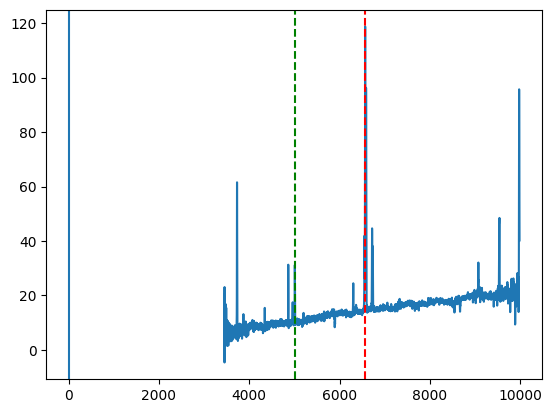

In [20]:
plt.plot(10**(sp[0][1].data['loglam'])/(1+0.04072),sp[0][1].data['flux'])
plt.axvline(6562,label=r'H$\alpha$',color='r',ls='--')
plt.axvline(5007,label='OIII',color='g',ls='--')
plt.axvline()

In [21]:
sp[0][3].data
#result = SDSS.query_specobj()

FITS_rec([(5164, 56067, 630, 'Ly_alpha', 1215.67      , 0.        , -1.0000000e+00,   0.     , -1.       ,  0.0000000e+00, -1.       ,  0.0000000e+00, -1.        ,  0.       , -1.        , 0, 0,  0.      ,  -1.      ),
          (5164, 56067, 630, 'N_V 1240', 1240.81      , 0.        , -1.0000000e+00,   0.     , -1.       ,  0.0000000e+00, -1.       ,  0.0000000e+00, -1.        ,  0.       , -1.        , 0, 0,  0.      ,  -1.      ),
          (5164, 56067, 630, 'C_IV 1549', 1549.48      , 0.        , -1.0000000e+00,   0.     , -1.       ,  0.0000000e+00, -1.       ,  0.0000000e+00, -1.        ,  0.       , -1.        , 0, 0,  0.      ,  -1.      ),
          (5164, 56067, 630, 'He_II 1640', 1640.42      , 0.        , -1.0000000e+00,   0.     , -1.       ,  0.0000000e+00, -1.       ,  0.0000000e+00, -1.        ,  0.       , -1.        , 0, 0,  0.      ,  -1.      ),
          (5164, 56067, 630, 'C_III] 1908', 1908.734     , 0.        , -1.0000000e+00,   0.     , -1.       ,  0.0000000e

In [22]:
sp[0][3].data['LINENAME']

chararray(['Ly_alpha', 'N_V 1240', 'C_IV 1549', 'He_II 1640',
           'C_III] 1908', 'Mg_II 2799', '[O_II] 3725', '[O_II] 3727',
           '[Ne_III] 3868', 'H_zeta', '[Ne_III] 3970', 'H_epsilon',
           'H_delta', 'H_gamma', '[O_III] 4363', 'He_II 4685', 'H_beta',
           '[O_III] 4959', '[O_III] 5007', 'He_II 5411', '[O_I] 5577',
           '[N_II] 5755', 'He_I 5876', '[O_I] 6300', '[S_III] 6312',
           '[O_I] 6363', '[N_II] 6548', 'H_alpha', '[N_II] 6583',
           '[S_II] 6716', '[S_II] 6730', '[Ar_III] 7135'], dtype='<U13')

In [23]:
sp[0][3].data.names

['PLATE',
 'MJD',
 'FIBERID',
 'LINENAME',
 'LINEWAVE',
 'LINEZ',
 'LINEZ_ERR',
 'LINESIGMA',
 'LINESIGMA_ERR',
 'LINEAREA',
 'LINEAREA_ERR',
 'LINEEW',
 'LINEEW_ERR',
 'LINECONTLEVEL',
 'LINECONTLEVEL_ERR',
 'LINENPIXLEFT',
 'LINENPIXRIGHT',
 'LINEDOF',
 'LINECHI2']

In [24]:
nii = sp[0][3].data['LINEEW'][sp[0][3].data['LINENAME'] == '[N_II] 6583'][0]
h_alpha = sp[0][3].data['LINEEW'][sp[0][3].data['LINENAME'] == 'H_alpha'][0]
oiii = sp[0][3].data['LINEEW'][sp[0][3].data['LINENAME'] == '[O_III] 5007'][0]
h_beta = sp[0][3].data['LINEEW'][sp[0][3].data['LINENAME'] == 'H_beta'][0]
bptx = np.log10(nii/h_alpha)
bpty = np.log10(oiii/h_beta)
print(bptx,bpty)

-0.053928666 0.08884971


Looking at BPT diagrams online, this means our galaxy has a composite (starbust + AGN) spectrum!

### Class Exercise: How much is this spectrum affected by dust extinction?

The equation is $E(B-V) = 1.97log_{10}\frac{H\alpha/H\beta}{2.86}$

## 4. Working with Published Data

Let's try and grab some data from a published paper with the idea of setting ourselves up to reproduce an analysis

### 4a. Vizier

https://ui.adsabs.harvard.edu/abs/2009ApJ...707.1449N/abstract

### 4b. GitHub
https://ui.adsabs.harvard.edu/abs/2024PDU....4601582P/abstract

https://github.com/MarinePrunier/Analysis-Of-Subsolar-Mass-Black-Hole-Candidate-In-Advanced-LIGO-Virgo-Data/

### 4c. Random Webpages
Let's try cosmicflows-4: https://ui.adsabs.harvard.edu/abs/2023ApJ...944...94T/abstract, which links to https://edd.ifa.hawaii.edu/

### Class Exercise: Find data or software from a paper you're interested in